# Using extrapolation to power law fits to measure mass for HSC-like sample of TNG galaxies

In [1]:
import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import glob
import random

from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import interp1d

from astropy.table import Table

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]
  


In [2]:
def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=150):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)

    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25,
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'intens_kpc':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(gal[quantity]),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(gal[quantity]),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'extrapolated':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(mu_extrap(gal)),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'ratio':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25,
                                               mu_extrap(gal)/mu_iso(gal, pixel_scale),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)

    return sma_common, mu

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

def hsc_quantity_in_bin(hsc_gals, mass_bins, quantity, mass_type):
    '''
    returns hsc quantity (e.g. profiles) in given mass bin
    '''
    
    #halo mass bins
    n_bins = len(mass_bins) - 1
    
    profiles_in_bins=[]
    
    if mass_type == 'halo':
        masses = hsc_gals['logmh_vir_symbol']
    elif mass_type == 'm100':
        masses = hsc_gals['logm_100']
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        sbps = hsc_gals[quantity][(masses>lower) & (masses<upper)]
        
        profiles_in_bins.append(sbps)
        
    return profiles_in_bins

def mu_extrap(iso, ini_r=50, final_r=100):
    power_law_iso = np.log10(powerlaw(iso['sma_kpc'],*fit_power_law_to_iso(iso, ini_r, final_r)))
    return 10**(power_law_iso+ np.log10(0.7 ** 2.0))


## Load TNG data

In [4]:
#open pickels
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_merged.pkl'
tng_isos_varying_geometry_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_varying_geometry_highres.pkl'


tng_masses = open_pkl(tng_masses_file)
tng_isos = open_pkl(tng_isos_file)
tng_isos_varying_geometry = open_pkl(tng_isos_varying_geometry_file)


In [17]:
#get halo masses
TNG_mass_map_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'
f = h5py.File(TNG_mass_map_file, 'r')
M200c = np.array(f['catgrp_Group_M_Crit200'])
f.close()


## create HSC-like sample of TNG galaxies 

for every HSC galaxy, select a TNG galaxy with similar M10 and M100

do extrapolation tests with these

In [6]:
################################################################################
#HSC
hsc_data_location='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'

# Universal RSMA array
hsc_sma = np.arange(0.4, 4.2, 0.01)

#masses
hsc_file = hsc_data_location+'s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)


In [7]:
np.random.seed(200)
rows_numbers_to_keep = np.random.choice(len(hsc_table), 50, replace=False)
reduced_hsc_table = hsc_table[rows_numbers_to_keep]
rows_numbers_to_keep

array([12569,  5729,  6663, 14695,  1420, 11137,  5931, 14376,  1712,
       11337, 13132,  2538, 21475, 12049,  7689,  8258, 11363,  4925,
       10100, 19605, 24685, 18451, 18114,   593,  2749,  1140, 11482,
       14721, 25319, 23759,  5642, 23198, 22106,  8848, 13759, 10008,
       14974,  3967,  9481, 13668,  7829, 10081, 15380, 17683, 10355,
       22830,  3884, 12730, 23371,  8274])

In [8]:
similar_ids=[]
for hsc_gal in reduced_hsc_table:
    
    distances = np.sqrt((tng_masses['m_1d_100']-hsc_gal['logm_100'])**2 + (tng_masses['m_1d_10']-hsc_gal['logm_10'])**2)
    sorted_tng_indices = np.argsort(distances)
    
    i=0
    closest_tng_index = sorted_tng_indices[i]
    
    #if already in list, loop until one isn't
    while closest_tng_index in similar_ids:
        i+=1
        closest_tng_index = sorted_tng_indices[i]
        
    similar_ids.append(closest_tng_index)
    print distances[closest_tng_index]

similar_tng_isos = np.array(tng_isos)[similar_ids]
similar_tng_masses = tng_masses[similar_ids]



0.015099325938162635
0.012811565368639064
0.009813189475368342
0.02029458278139614
0.010182048444428682
0.015298211054785002
0.03883620326604923
0.020396216078421042
0.04007313352707807
0.0230295522525054
0.07731309455616255
0.029746748480450683
0.01673110258303917
0.040348597138922665
0.02174569675702933
0.04541374481151031
0.012003303220200583
0.007130655293485372
0.014344583701340051
0.05731133255772724
0.010657503157029347
0.027677386721114926
0.008686587310242763
0.04620423573679942
0.06400769466557228
0.023252304449757757
0.007686524499873757
0.025237207027070184
0.09611214840367169
0.07269109494754013
0.0079242652795502
0.009028771553199349
0.02517326409561375
0.04446352676719269
0.03046216545259593
0.01551264074711771
0.0483491249678109
0.06629695757048956
0.044894385398216066
0.034588185725929255
0.14121312844776093
0.002271595677417631
0.03675372612976478
0.016778150680928708
0.04216476121374443
0.03852011370438505
0.061646257226050494
0.021817329254937352
0.00285988372314287

In [12]:
print len(similar_ids), len(np.unique(similar_ids))

50 50


/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


50


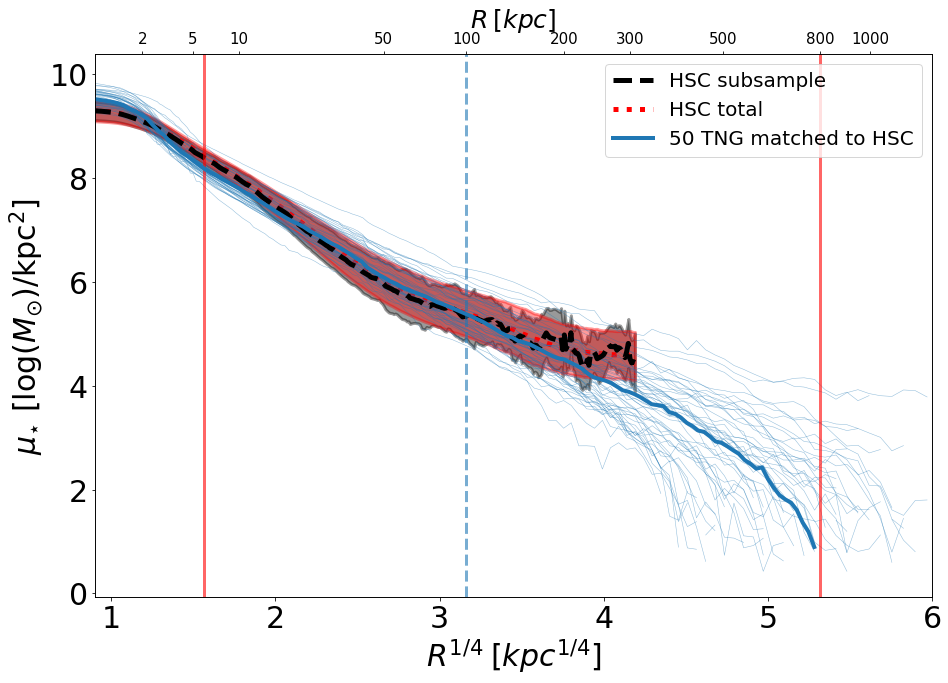

In [13]:
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################
#hsc
hsc_median1 = np.nanmedian(reduced_hsc_table['sbp'], axis=0)
hsc_median2 = np.nanmedian(hsc_table['sbp'], axis=0)
#stds (masked_invalid to exclude infinities)
hsc_std1 = np.nanstd(np.ma.masked_invalid(reduced_hsc_table['sbp']),axis=0)
hsc_std2 = np.nanstd(np.ma.masked_invalid(hsc_table['sbp']),axis=0)

ax1.plot(hsc_sma, hsc_median1, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC subsample')
ax1.plot(hsc_sma, hsc_median2, linestyle=':', linewidth=5.0, c='r', alpha=1, zorder=1, label='HSC total')

ax1.fill_between(hsc_sma, hsc_median1+hsc_std1, hsc_median1-hsc_std1, alpha=0.4, color='k', zorder=1, linewidth=3)
ax1.fill_between(hsc_sma, hsc_median2+hsc_std2, hsc_median2-hsc_std2, alpha=0.4, color='r', zorder=1, linewidth=3)


#TNG

for iso in similar_tng_isos:   

        ngals1+=1

        #tng_isos1.append(iso)

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


# ## median profiles for tng
median_sma1, median_mu1 = get_median_profile(similar_tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='50 TNG matched to HSC', zorder=8)


print ngals1


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 6)
#ax1.set_ylim(-2, 10)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_tng.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

In [22]:
similar_tng_masses

m_1d_10,m_1d_30,m_1d_100,m_1d_500,m_1d_800,m_2d_10,m_2d_30,m_2d_100,m_2d_500,m_2d_800,extrapolated_m_300,extrapolated_m_500,extrapolated_m_800,m_cat,m_post,m_post_icl
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11.118321079780015,11.287489322760603,11.369117345614516,11.384982162544512,11.384982162544512,11.163487310255505,11.325669323496344,11.405080470773633,11.42466374237932,11.42466374237932,11.405888650488622,11.415481222036611,11.421830892007522,11.446577434654298,11.424663744174474,11.424724101215542
11.086901360189735,11.230323551020529,11.29757657971815,11.306464193086342,11.306464193086342,11.122053015359961,11.262155899975157,11.32805457537951,11.336320536084733,11.336320536084733,11.31514149736916,11.318084980177558,11.319597532664416,11.340397044874313,11.336320535852748,11.33632606595042
11.143220573682918,11.40029217906579,11.528816735259086,11.558618733011183,11.558618733011183,11.165894192096811,11.40653456144144,11.518478813641288,11.537112110100766,11.537112110100766,11.581947496282542,11.593432653305516,11.600322050143525,11.543368044971611,11.5371121109051,11.537118525516776
11.128926628557126,11.314641437782482,11.403300283048523,11.419860273190046,11.419860273190046,11.147740805807262,11.33787908292166,11.431743867063012,11.448827931133543,11.448827931133543,11.42898709962885,11.433556387681273,11.435991281523373,11.455801365940301,11.44882792980078,11.448848428962943
11.167661039800233,11.315025994464197,11.41969274919454,11.49339965240941,11.49339965240941,11.072327390323666,11.212040056597383,11.336420724204778,11.452726621231038,11.453215523668609,11.572607213455294,11.628100101153303,11.673241139470546,11.498809116908497,11.45321552231051,11.453235593511877
11.042899568306545,11.231475653017212,11.295982785364078,11.338860607393032,11.338860607393032,11.079029137789517,11.241901776501965,11.295076374223745,11.323053263112486,11.323053263112486,11.350272277181652,11.371660957037681,11.389588498623215,11.34654113822936,11.323053262889447,11.323193087556778
11.311151406117824,11.510309280842948,11.652965193084166,11.711071893426727,11.711071893426727,11.338018480421576,11.531365177961668,11.670714623959237,11.725434800175792,11.725434800175792,11.78178692829761,11.834666949839548,11.880332753085138,11.84346327419548,11.725434801101303,11.725900136749436
11.33978343626982,11.470204449155872,11.559899852956374,11.57534295563788,11.57534295563788,11.380551200538576,11.506460268168373,11.596145032676773,11.612832047006444,11.612832047006444,11.599176926725189,11.608869774926601,11.615094917040368,11.629157418881787,11.612832046039022,11.612834493533475
11.046697815009415,11.180933715967154,11.231088885226548,11.236983533619902,11.236983533619902,11.093146956856875,11.221255697829717,11.270286093058706,11.27655874594257,11.27655874594257,11.246887437092127,11.250139152545485,11.252009848197163,11.279291886979316,11.276558748230292,11.276558748230292


## plot difference between mass from extrapolation and catalog mass for different extrapolation radii 

<function matplotlib.pyplot.show>

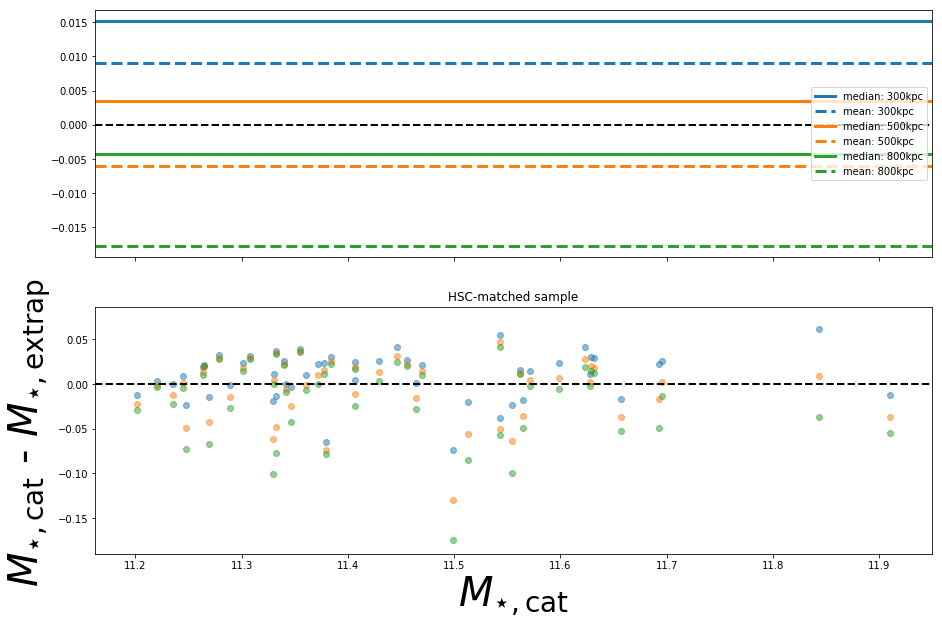

In [23]:
fig, axes = plt.subplots(2,1, figsize=(15, 10), sharex=True)
axes[1].scatter(similar_tng_masses['m_cat'], similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_300'], alpha=0.5)
axes[1].scatter(similar_tng_masses['m_cat'], similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_500'], alpha=0.5)
axes[1].scatter(similar_tng_masses['m_cat'], similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_800'], alpha=0.5)

axes[0].axhline(np.median(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_300']),
            color='C0', linewidth=3, label = 'median: 300kpc')
axes[0].axhline(np.mean(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_300']),
            linestyle='--', linewidth=3, color='C0', label = 'mean: 300kpc')

axes[0].axhline(np.median(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_500']),
            color='C1', linewidth=3, label = 'median: 500kpc')
axes[0].axhline(np.mean(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_500']),
            linestyle='--', linewidth=3, color='C1', label = 'mean: 500kpc')

axes[0].axhline(np.median(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_800']),
            color='C2', linewidth=3, label = 'median: 800kpc')
axes[0].axhline(np.mean(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_800']),
            linestyle='--', linewidth=3, color='C2', label = 'mean: 800kpc')


axes[1].axhline(0,c="k",linewidth=2,linestyle='--')
axes[0].axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star, \mathrm{cat}}$ - $M_{\star, \mathrm{{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star, \mathrm{cat}}$', fontsize=40)
plt.title('HSC-matched sample')
axes[0].legend(loc='right')
# axes[1].set_ylim([-0.05,0.05])
plt.show

## All TNG galaxies 

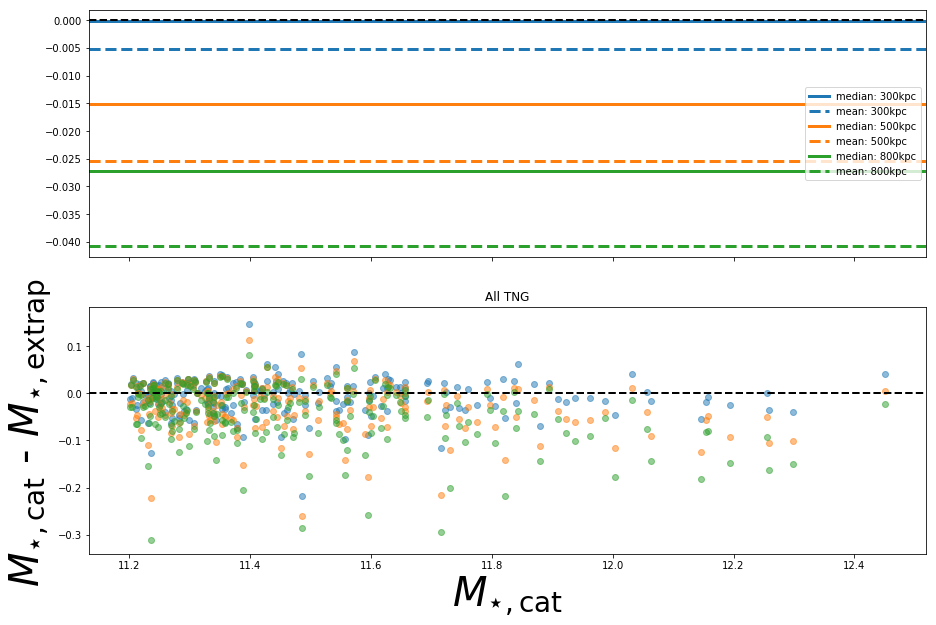

In [24]:
fig, axes = plt.subplots(2,1, figsize=(15, 10), sharex=True)
axes[1].scatter(tng_masses['m_cat'], tng_masses['m_cat']-tng_masses['extrapolated_m_300'], alpha=0.5)
axes[1].scatter(tng_masses['m_cat'], tng_masses['m_cat']-tng_masses['extrapolated_m_500'], alpha=0.5)
axes[1].scatter(tng_masses['m_cat'], tng_masses['m_cat']-tng_masses['extrapolated_m_800'], alpha=0.5)

axes[0].axhline(np.median(tng_masses['m_cat']-tng_masses['extrapolated_m_300']),
            color='C0', linewidth=3, label = 'median: 300kpc')
axes[0].axhline(np.mean(tng_masses['m_cat']-tng_masses['extrapolated_m_300']),
            linestyle='--', linewidth=3, color='C0', label = 'mean: 300kpc')

axes[0].axhline(np.median(tng_masses['m_cat']-tng_masses['extrapolated_m_500']),
            color='C1', linewidth=3, label = 'median: 500kpc')
axes[0].axhline(np.mean(tng_masses['m_cat']-tng_masses['extrapolated_m_500']),
            linestyle='--', linewidth=3, color='C1', label = 'mean: 500kpc')

axes[0].axhline(np.median(tng_masses['m_cat']-tng_masses['extrapolated_m_800']),
            color='C2', linewidth=3, label = 'median: 800kpc')
axes[0].axhline(np.mean(tng_masses['m_cat']-tng_masses['extrapolated_m_800']),
            linestyle='--', linewidth=3, color='C2', label = 'mean: 800kpc')


axes[1].axhline(0,c="k",linewidth=2,linestyle='--')
axes[0].axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star, \mathrm{cat}}$ - $M_{\star, \mathrm{{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star, \mathrm{cat}}$', fontsize=40)
plt.title('All TNG') #remove
axes[0].legend(loc='right')
# axes[1].set_ylim([-0.05,0.05])
plt.show()

## plot profiles and extrapolations


/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


50


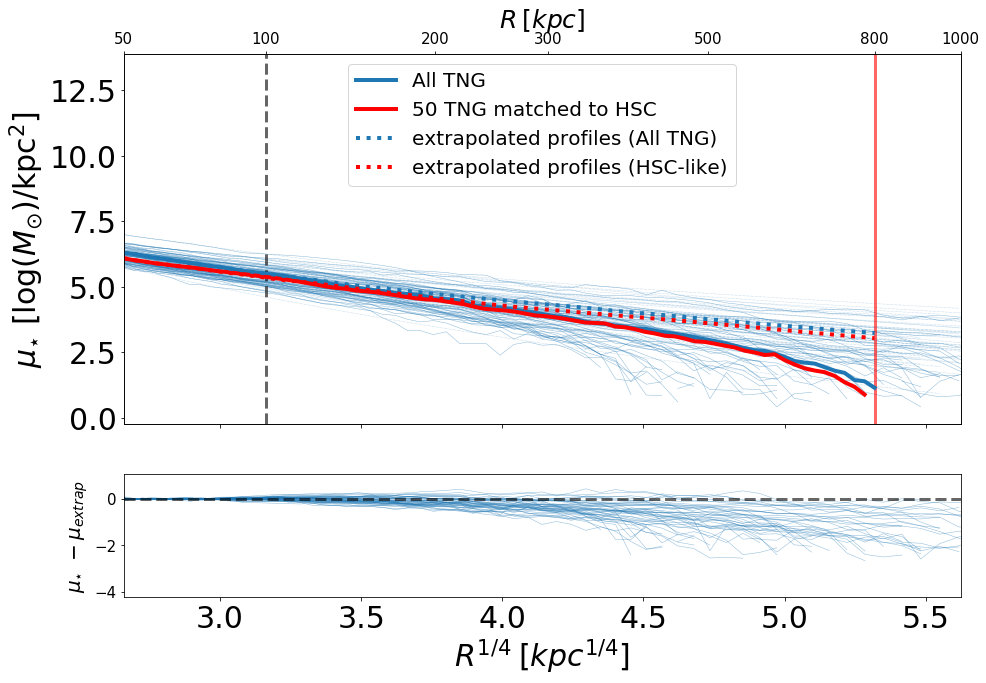

In [68]:
ngals1=0

#plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})


######################################################################################################################
# plot
######################################################################################################################

#TNG

for iso in similar_tng_isos[:]:   

        ngals1+=1

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)
        

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c=u'#1f77b4', alpha=0.5, linestyle=':', 
                 label='_nolegend_', zorder=1)
        
        #plot difference
        ax2.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) - np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)


# ## median profiles for tng
median_sma1, median_mu1 = get_median_profile(similar_tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)
median_sma_all, median_mu_all = get_median_profile(tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)

median_sma_extrap, median_mu_extrap = get_median_profile(similar_tng_isos, quantity='extrapolated', pixel_scale = 1,
                                             rmax=800.**0.25)
median_sma_extrap_all, median_mu_extrap_all = get_median_profile(tng_isos, quantity='extrapolated', pixel_scale = 1,
                                             rmax=800.**0.25)

ax1.plot(median_sma_all, median_mu_all+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='All TNG',
         zorder=8)
ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c='r', alpha=1, label='50 TNG matched to HSC',
         zorder=8)

ax1.plot(median_sma_extrap_all, median_mu_extrap_all, linewidth=4.0, c=u'#1f77b4', alpha=1, label='extrapolated profiles (All TNG)',
         zorder=8, linestyle=':')
ax1.plot(median_sma_extrap, median_mu_extrap, linewidth=4.0, c='r', alpha=1, label='extrapolated profiles (HSC-like)',
         zorder=8, linestyle=':')


print ngals1


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 6)
#ax1.set_ylim(-2, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
ax1.set_xlim([50**0.25,1000**0.25])
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_ylabel(r'$\mu_{\star}\ - \mu_{extrap}$ ', fontsize=20)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='k')
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax2.axhline(0, linestyle='--', linewidth=3.0, alpha=0.6, c='k')


######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_tng.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## just HSC-like galaxies in TNG 

/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


50


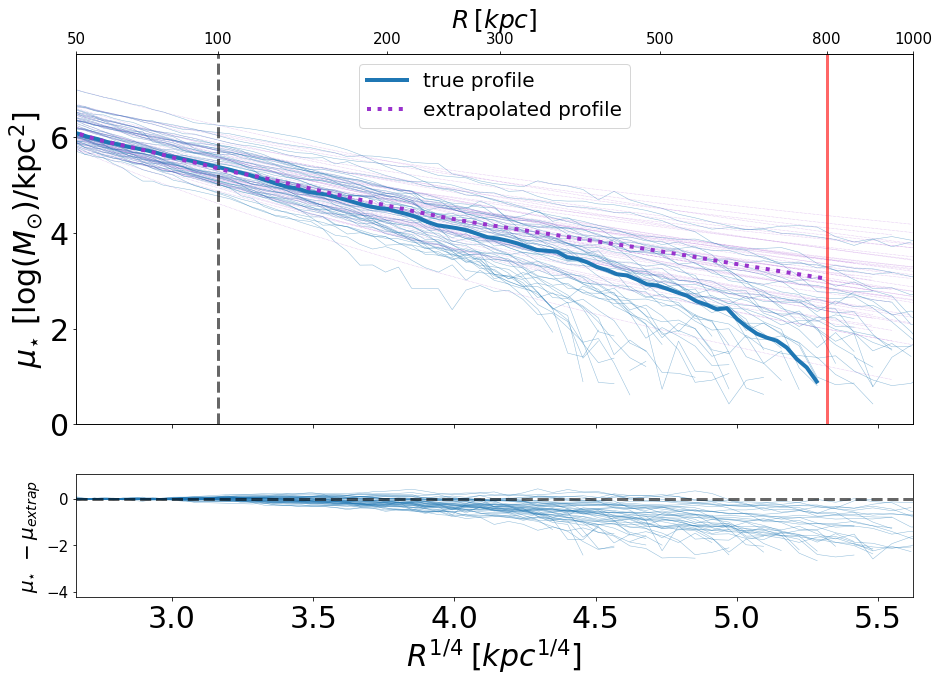

In [81]:
ngals1=0

#plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})


######################################################################################################################
# plot
######################################################################################################################

#TNG

for iso in similar_tng_isos[:]:   

        ngals1+=1

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)
        

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c='darkorchid', alpha=0.5, linestyle=':', 
                 label='_nolegend_', zorder=1)
        
        #plot difference
        ax2.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) - np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)


# ## median profiles for tng
median_sma1, median_mu1 = get_median_profile(similar_tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)
# median_sma_all, median_mu_all = get_median_profile(tng_isos, quantity='intens_kpc', pixel_scale = 1,
#                                              rmax=800.**0.25)

median_sma_extrap, median_mu_extrap = get_median_profile(similar_tng_isos, quantity='extrapolated', pixel_scale = 1,
                                             rmax=800.**0.25)
# median_sma_extrap_all, median_mu_extrap_all = get_median_profile(tng_isos, quantity='extrapolated', pixel_scale = 1,
#                                              rmax=800.**0.25)

# ax1.plot(median_sma_all, median_mu_all+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='All TNG',
#          zorder=8)
ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='true profile',
         zorder=8)

# ax1.plot(median_sma_extrap_all, median_mu_extrap_all, linewidth=4.0, c=u'#1f77b4', alpha=1, label='extrapolated profiles (All TNG)',
#          zorder=8, linestyle=':')
ax1.plot(median_sma_extrap, median_mu_extrap, linewidth=4.0, c='darkorchid', alpha=1, label='extrapolated profile',
         zorder=8, linestyle=':')


print ngals1


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim([50**0.25,1000**0.25])
ax1.set_ylim(0, 7.75)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc

x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_ylabel(r'$\mu_{\star}\ - \mu_{extrap}$ ', fontsize=20)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='k')
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax2.axhline(0, linestyle='--', linewidth=3.0, alpha=0.6, c='k')


######################################################################################################################
#adjustments to ticks and space between subplots

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/extrapolation.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()